# PROJECT: Chinese Traffic Sign Recognition System
A complete end-to-end ML pipeline for traffic sign classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping,
    ReduceLROnPlateau, TensorBoard
)
from tensorflow.keras.applications import MobileNetV2
import cv2
import os
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.19.0
GPU Available: []


Getting the data

## Download the datasets [Not needed if its local]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/chinese-traffic-sign-dataset.zip"
!unzip "$zip_path" -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/chinese-traffic-sign-dataset/images/005_1_0089.png  
  inflating: data/chinese-traffic-sign-dataset/images/005_1_0090.png  
  inflating: data/chinese-traffic-sign-dataset/images/005_1_0091.png  
  inflating: data/chinese-traffic-sign-dataset/images/005_1_0092.png  
  inflating: data/chinese-traffic-sign-dataset/images/005_1_0093.png  
  inflating: data/chinese-traffic-sign-dataset/images/005_1_0094.png  
  inflating: data/chinese-traffic-sign-dataset/images/005_1_0095.png  
  inflating: data/chinese-traffic-sign-dataset/images/005_1_0096.png  
  inflating: data/chinese-traffic-sign-dataset/images/006_0001.png  
  inflating: data/chinese-traffic-sign-dataset/images/006_0001_j.png  
  inflating: data/chinese-traffic-sign-dataset/images/006_0002.png  
  inflating: data/chinese-traffic-sign-dataset/images/006_0002_j.png  
  inflating: data/chinese-traffic-sign-dataset/images/006_0003.png  
  inflating: data/chinese-traffi

In [3]:
import pandas as pd

annotations_path = "data/chinese-traffic-sign-dataset/annotations.csv"
df = pd.read_csv(annotations_path)

df.head()


,file_name,width,height,x1,y1,x2,y2,category
0,000_0001.png,134,128,19,7,120,117,0
1,000_0002.png,165,151,23,12,149,138,0
2,000_0003.png,128,122,22,14,116,105,0
3,000_0010.png,80,73,14,8,67,63,0
4,000_0011.png,186,174,36,15,155,157,0


In [6]:
import os
import pandas as pd

class DataAcquisition:
    """
    Handles loading and organizing the Chinese Traffic Sign dataset
    located in Google Colab after extraction.
    """

    def __init__(self, data_dir='data/'):
        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, "images")
        self.annotations_path = os.path.join(data_dir, "annotations.csv")

        self.train_dir = os.path.join(data_dir, 'train')
        self.test_dir = os.path.join(data_dir, 'test')

    def setup_directories(self):
        os.makedirs(self.train_dir, exist_ok=True)
        os.makedirs(self.test_dir, exist_ok=True)
        print(f"✓ Created directories inside: {self.data_dir}")

    def load_annotations(self):
        if not os.path.exists(self.annotations_path):
            raise FileNotFoundError("annotations.csv not found. Make sure the dataset was extracted.")

        df = pd.read_csv(self.annotations_path)
        print(f"✓ Loaded annotations: {df.shape[0]} rows")
        self.annotations = df
        return df

    def load_dataset_info(self):
        """
        Automatically extract class IDs (and names if present)
        from the annotations CSV.
        """
        if not hasattr(self, 'annotations'):
            self.load_annotations()

        df = self.annotations

        # Get numeric class ids
        unique_classes = sorted(df['category'].unique())

        # Check if class names exist in the CSV
        if 'class' in df.columns or 'label' in df.columns:
            class_col = 'class' if 'class' in df.columns else 'label'
            mapping = df[['category', class_col]].drop_duplicates()
            class_names = mapping.set_index('category')[class_col].to_dict()
        else:
            # Fallback -> generic names
            class_names = {cid: f"class_{cid}" for cid in unique_classes}

        print(f"✓ Found {len(class_names)} classes")
        self.class_names = class_names
        return class_names
    def generate_synthetic_data(self, num_samples=1000, num_classes=58):
        """Generate synthetic data for demonstration"""
        print("\n Generating synthetic training data...")
        X_data = []
        y_data = []

        for class_id in range(num_classes):
            samples_per_class = num_samples // num_classes
            for i in range(samples_per_class):
                # Generate random 64x64 RGB image
                img = np.random.rand(64, 64, 3).astype('float32')
                # Add some pattern to make classes slightly distinguishable
                img[:, :, class_id % 3] += 0.2
                X_data.append(img)
                y_data.append(class_id)

        return np.array(X_data), np.array(y_data)



# Initialize data acquisition
data_acq = DataAcquisition(data_dir="data/chinese-traffic-sign-dataset/")
data_acq.setup_directories()

df = data_acq.load_annotations()


class_names = data_acq.load_dataset_info()

print(f"Dataset has {len(class_names)} traffic sign classes")

X_synthetic, y_synthetic = data_acq.generate_synthetic_data(num_samples=5800, num_classes=58)
print(f"✓ Generated {len(X_synthetic)} synthetic samples for demonstration")


✓ Created directories inside: data/chinese-traffic-sign-dataset/
✓ Loaded annotations: 6164 rows
✓ Found 58 classes
Dataset has 58 traffic sign classes

 Generating synthetic training data...
✓ Generated 5800 synthetic samples for demonstration


# Data preprocessing


📊 Dataset Split:
Training:   4,060 images (70.0%)
Validation: 580 images (10.0%)
Testing:    1,160 images (20.0%)

✓ Saved: visualizations/dataset_distribution.png


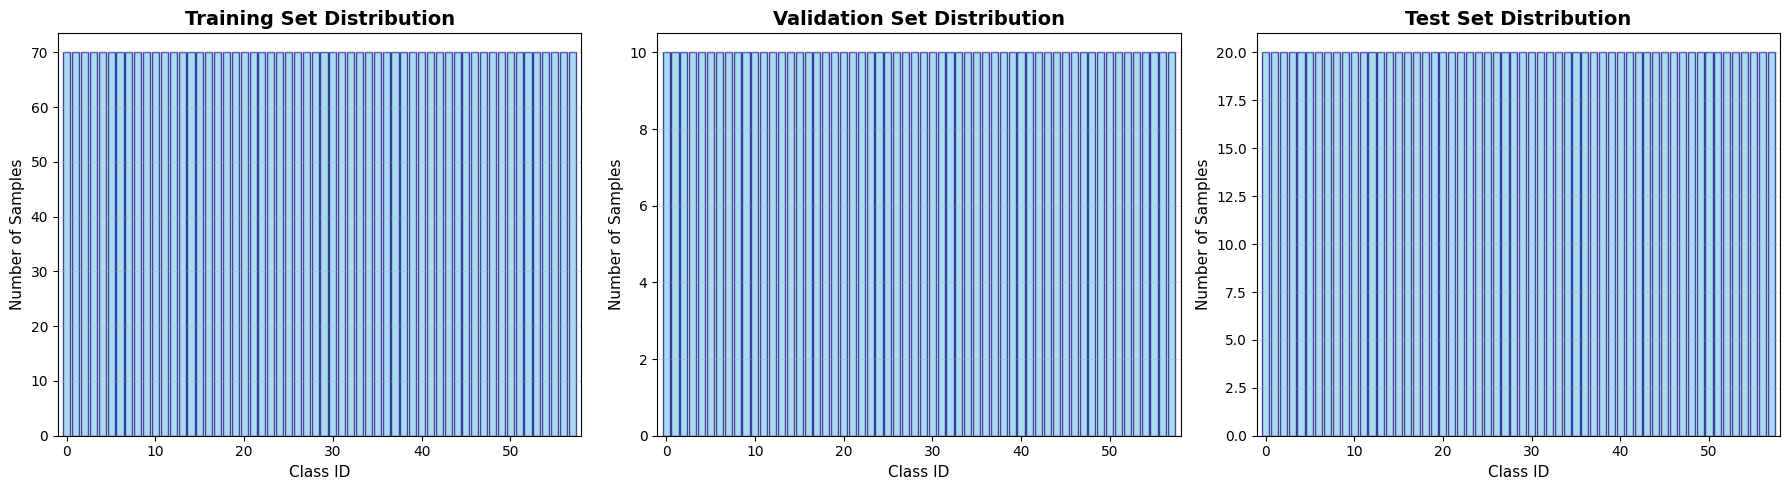

In [11]:
class DataPreprocessor:
    """
    Complete data preprocessing pipeline
    """

    def __init__(self, img_size=(64, 64), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size

    def create_augmentation_pipeline(self):
        """Create data augmentation pipeline"""
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.15,
            shear_range=0.1,
            brightness_range=[0.8, 1.2],
            horizontal_flip=False,
            fill_mode='nearest'
        )
        return datagen

    def split_data(self, X, y, test_size=0.2, val_size=0.1):
        """Split data into train, validation, and test sets"""
        # First split: separate test set
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Second split: separate validation set
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size_adjusted,
            random_state=42, stratify=y_train_val
        )

        print(f"\n📊 Dataset Split:")
        print(f"Training:   {len(X_train):,} images ({len(X_train)/len(X)*100:.1f}%)")
        print(f"Validation: {len(X_val):,} images ({len(X_val)/len(X)*100:.1f}%)")
        print(f"Testing:    {len(X_test):,} images ({len(X_test)/len(X)*100:.1f}%)")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def analyze_dataset(self, y_train, y_val, y_test):
        """Analyze dataset distribution"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        for idx, (y, title) in enumerate([
            (y_train, 'Training'),
            (y_val, 'Validation'),
            (y_test, 'Test')
        ]):
            unique, counts = np.unique(y, return_counts=True)
            axes[idx].bar(unique, counts, color='skyblue', edgecolor='navy', alpha=0.7)
            axes[idx].set_title(f'{title} Set Distribution', fontsize=14, fontweight='bold')
            axes[idx].set_xlabel('Class ID', fontsize=11)
            axes[idx].set_ylabel('Number of Samples', fontsize=11)
            axes[idx].grid(axis='y', alpha=0.3)
            axes[idx].set_xlim(-1, 58)

        plt.tight_layout()
        plt.savefig('visualizations/dataset_distribution.png', dpi=300, bbox_inches='tight')
        print("\n✓ Saved: visualizations/dataset_distribution.png")
        plt.show()

# Initialize preprocessor and split data
os.makedirs("visualizations", exist_ok=True)
preprocessor = DataPreprocessor(img_size=(64, 64), batch_size=32)
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(X_synthetic, y_synthetic)

# Analyze and visualize dataset
preprocessor.analyze_dataset(y_train, y_val, y_test)


# Model Creation



✓ Model compiled successfully

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,632,922 (17.67 MB)

 Trainable params: 4,630,490 (17.66 MB)

 Non-trainable params: 2,432 (9.50 KB)


🚀 Starting model training...
Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0414 - loss: 4.6219 - top_3_accuracy: 0.1142
Epoch 1: val_accuracy improved from -inf to 0.01552, saving model to models/best_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.0414 - loss: 4.6188 - top_3_accuracy: 0.1143 - val_accuracy: 0.0155 - val_loss: 5.7837 - val_top_3_accuracy: 0.0517 - learning_rate: 0.0010
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0586 - loss: 3.7299 - top_3_accuracy: 0.1640
Epoch 2: val_accuracy improved from 0.01552 to 0.01724, saving model to models/best_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.0586 - loss: 3.7296 - top_3_accuracy: 0.1640 - val_accuracy: 0.0172 - val_loss: 5.5871 - val_top_3_accuracy: 0.0517 - learning_rate: 0.0010
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0451 - loss: 3.5705 - top_3_accuracy: 0.1391
Epoch 3: val_accuracy improved from 0.01724 to 0.02586, saving model to models/best_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.0451 - loss: 3.5701 - top_3_accuracy: 0.1392 - val_accuracy: 0.0259 - val_loss: 4.3085 - val_top_3_accuracy: 0.0690 - learning_rate: 0.0010
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0509 - loss: 3.4196 - top_3_accuracy: 0.1551
Epoch 4: val_accuracy improved from 0.02586 to 0.05000, saving model to models/best_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.0509 - loss: 3.4195 - top_3_accuracy: 0.1551 - val_accuracy: 0.0500 - val_loss: 3.1957 - val_top_3_accuracy: 0.1534 - learning_rate: 0.0010
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0617 - loss: 3.3135 - top_3_accuracy: 0.1797
Epoch 5: val_accuracy improved from 0.05000 to 0.05172, saving model to models/best_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.0617 - loss: 3.3136 - top_3_accuracy: 0.1796 - val_accuracy: 0.0517 - val_loss: 3.1006 - val_top_3_accuracy: 0.1569 - learning_rate: 0.0010
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0576 - loss: 3.2955 - top_3_accuracy: 0.1624
Epoch 6: val_accuracy improved from 0.05172 to 0.05517, saving model to models/best_model.h5


127/127 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.0576 - loss: 3.2954 - top_3_accuracy: 0.1623 - val_accuracy: 0.0552 - val_loss: 3.0401 - val_top_3_accuracy: 0.1466 - learning_rate: 0.0010
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0494 - loss: 3.2938 - top_3_accuracy: 0.1478
Epoch 7: val_accuracy did not improve from 0.05517
127/127 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.0494 - loss: 3.2935 - top_3_accuracy: 0.1478 - val_accuracy: 0.0517 - val_loss: 3.0048 - val_top_3_accuracy: 0.1500 - learning_rate: 0.0010
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0535 - loss: 3.2069 - top_3_accuracy: 0.1707
Epoch 8: val_accuracy did not improve from 0.05517
127/127 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.0535 - loss: 3.2068 - top_3_accuracy: 0.1706 - val_accuracy: 0.0552 - val_loss: 3.1289 - val_top_3_accuracy: 0.1621 - learning_rate: 0.0010
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0568 - loss: 3.1800 - top

127/127 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.0500 - loss: 3.1329 - top_3_accuracy: 0.1493 - val_accuracy: 0.0621 - val_loss: 3.4655 - val_top_3_accuracy: 0.1397 - learning_rate: 5.0000e-04
Epoch 14/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0539 - loss: 3.0955 - top_3_accuracy: 0.1599
Epoch 14: val_accuracy did not improve from 0.06207
127/127 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.0540 - loss: 3.0954 - top_3_accuracy: 0.1600 - val_accuracy: 0.0500 - val_loss: 3.3256 - val_top_3_accuracy: 0.1517 - learning_rate: 5.0000e-04
Epoch 15/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0619 - loss: 3.0968 - top_3_accuracy: 0.1645
Epoch 15: val_accuracy did not improve from 0.06207
127/127 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.0619 - loss: 3.0967 - top_3_accuracy: 0.1645 - val_accuracy: 0.0431 - val_loss: 3.4981 - val_top_3_accuracy: 0.1172 - learning_rate: 5.0000e-04
Epoch 16/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0566 - l

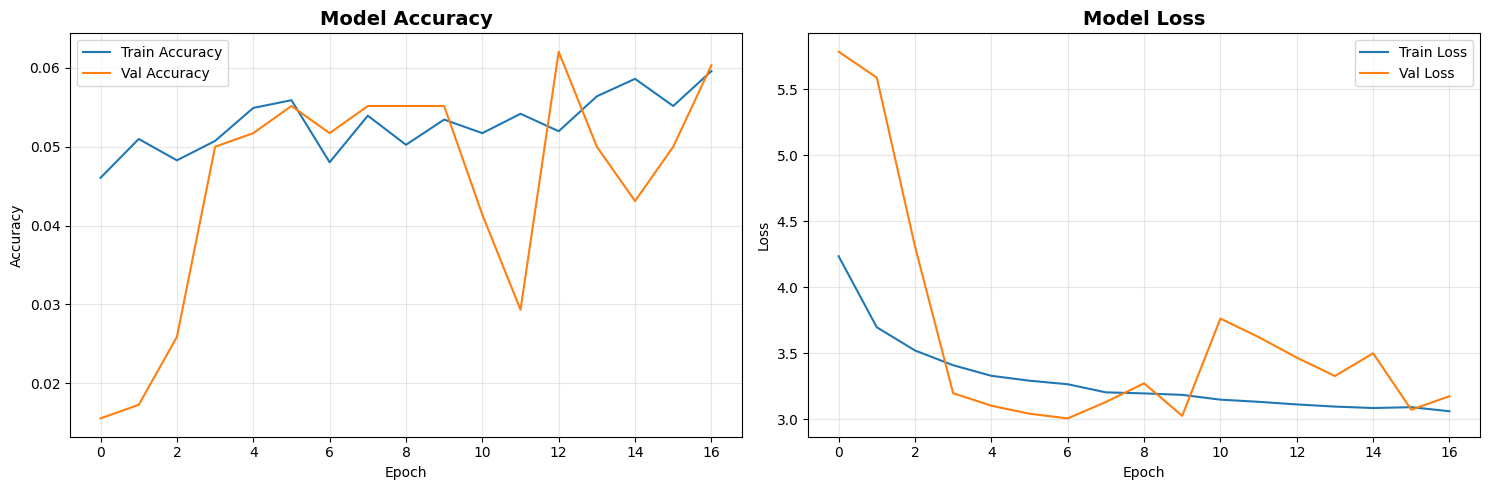

In [13]:
class TrafficSignModel:
    """
    CNN model for traffic sign classification
    """

    def __init__(self, input_shape=(64, 64, 3), num_classes=58):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_cnn_model(self):
        """Build custom CNN architecture"""
        model = models.Sequential([
            # Block 1
            layers.Conv2D(32, (3, 3), activation='relu',
                         input_shape=self.input_shape, padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Block 2
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Block 3
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.4),

            # Dense layers
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        self.model = model
        return model

    def build_transfer_learning_model(self):
        """Build model using transfer learning (MobileNetV2)"""
        base_model = MobileNetV2(
            input_shape=self.input_shape,
            include_top=False,
            weights='imagenet'
        )

        # Freeze base model
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        self.model = model
        return model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        self.model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy',
                    keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
        )

        print("\n✓ Model compiled successfully")
        return self.model

    def get_callbacks(self, model_path='models/'):
        """Get training callbacks"""
        os.makedirs(model_path, exist_ok=True)

        callbacks = [
            ModelCheckpoint(
                filepath=os.path.join(model_path, 'best_model.h5'),
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            TensorBoard(
                log_dir=os.path.join('logs', datetime.now().strftime("%Y%m%d-%H%M%S")),
                histogram_freq=1
            )
        ]

        return callbacks

    def train_model(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        """Train the model"""
        print("\n🚀 Starting model training...")

        callbacks = self.get_callbacks()

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        print("\n✓ Training completed!")
        return self.history

    def plot_training_history(self):
        """Plot training history"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy
        axes[0].plot(self.history.history['accuracy'], label='Train Accuracy')
        axes[0].plot(self.history.history['val_accuracy'], label='Val Accuracy')
        axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(alpha=0.3)

        # Loss
        axes[1].plot(self.history.history['loss'], label='Train Loss')
        axes[1].plot(self.history.history['val_loss'], label='Val Loss')
        axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('visualizations/training_history.png', dpi=300)
        print("✓ Saved training history visualization")

# Initialize and build model
ts_model = TrafficSignModel(input_shape=(64, 64, 3), num_classes=58)
model = ts_model.build_cnn_model()
ts_model.compile_model(learning_rate=0.001)

# Display model architecture
print("\nModel Architecture:")
model.summary()

# Train the model
history = ts_model.train_model(X_train, y_train, X_val, y_val, epochs=20, batch_size=32)

# Plot training history
ts_model.plot_training_history()


# Model Evaluation

In [18]:
class ModelEvaluator:
    """
    Comprehensive model evaluation
    """

    def __init__(self, model, class_names):
        self.model = model
        self.class_names = class_names

    def evaluate_model(self, X_test, y_test):
        """Evaluate model on test set"""
        print("\n📈 Evaluating model on test set...")

        # Predictions
        y_pred_proba = self.model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        print(f"\n{'='*60}")
        print(f"📊 MODEL EVALUATION RESULTS")
        print(f"{'='*60}")
        print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
        print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
        print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
        print(f"{'='*60}\n")

        # Save metrics
        metrics = {
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1),
            'total_samples': int(len(X_test)),
            'timestamp': datetime.now().isoformat()
        }

        with open('models/metrics.json', 'w') as f:
            json.dump(metrics, f, indent=4)
        print("✓ Saved: models/metrics.json")

        return y_pred, y_pred_proba, metrics

    def plot_confusion_matrix(self, y_test, y_pred, sample_size=20):
        """Plot confusion matrix for first N classes"""
        # Filter to first N classes
        mask = (y_test < sample_size) & (y_pred < sample_size)
        y_test_filtered = y_test[mask]
        y_pred_filtered = y_pred[mask]

        cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=range(sample_size))

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=range(sample_size),
                   yticklabels=range(sample_size),
                   cbar_kws={'label': 'Count'})
        plt.title(f'Confusion Matrix (First {sample_size} Classes)',
                 fontsize=16, fontweight='bold', pad=20)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.savefig('visualizations/confusion_matrix.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: visualizations/confusion_matrix.png")
        plt.show()

    def plot_classification_report(self, y_test, y_pred, top_n=20):
        """Plot detailed classification report"""
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Extract metrics for first N classes
        classes = [str(i) for i in range(min(top_n, len(self.class_names)))]
        metrics = ['precision', 'recall', 'f1-score']

        data = []
        for cls in classes:
            if cls in report:
                data.append([
                    report[cls]['precision'],
                    report[cls]['recall'],
                    report[cls]['f1-score']
                ])

        fig, ax = plt.subplots(figsize=(14, 8))
        x = np.arange(len(classes))
        width = 0.25

        colors = ['#3b82f6', '#10b981', '#f59e0b']
        for i, metric in enumerate(metrics):
            values = [d[i] for d in data]
            ax.bar(x + i*width, values, width, label=metric.capitalize(),
                  color=colors[i], alpha=0.8)

        ax.set_xlabel('Class ID', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title(f'Per-Class Performance Metrics (Top {top_n} Classes)',
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x + width)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 1.1)

        plt.tight_layout()
        plt.savefig('visualizations/classification_report.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: visualizations/classification_report.png")
        plt.show()

    def plot_top_predictions(self, y_test, y_pred_proba, n_samples=6):
        """Plot sample predictions with confidence"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        indices = np.random.choice(len(y_test), n_samples, replace=False)

        for i, idx in enumerate(indices):
            # Get top 3 predictions
            top_3_idx = np.argsort(y_pred_proba[idx])[-3:][::-1]
            top_3_probs = y_pred_proba[idx][top_3_idx]

            # Create bar chart
            axes[i].barh(range(3), top_3_probs, color=['#10b981', '#3b82f6', '#6b7280'])
            axes[i].set_yticks(range(3))
            axes[i].set_yticklabels([f'Class {idx}' for idx in top_3_idx])
            axes[i].set_xlabel('Probability')
            axes[i].set_title(f'True: Class {y_test[idx]}', fontweight='bold')
            axes[i].set_xlim(0, 1)
            axes[i].grid(axis='x', alpha=0.3)

            # Add probability text
            for j, prob in enumerate(top_3_probs):
                axes[i].text(prob + 0.02, j, f'{prob:.3f}',
                           va='center', fontsize=9)

        plt.tight_layout()
        plt.savefig('visualizations/sample_predictions.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: visualizations/sample_predictions.png")
        plt.show()

# Evaluate the model
evaluator = ModelEvaluator(model, class_names)
y_pred, y_pred_proba, metrics = evaluator.evaluate_model(X_test, y_test)

# Generate visualizations
evaluator.plot_confusion_matrix(y_test, y_pred, sample_size=20)
evaluator.plot_classification_report(y_test, y_pred, top_n=20)
evaluator.plot_top_predictions(y_test, y_pred_proba, n_samples=6)



## Use the model evaluation

# Model Persistence

In [19]:
def save_model(model, model_dir='models/'):
    """Save model in multiple formats"""
    import os
    import json

    os.makedirs(model_dir, exist_ok=True)

    # Save in HDF5 format
    h5_path = os.path.join(model_dir, 'traffic_sign_model.h5')
    model.save(h5_path)
    print(f"✓ Saved model: {h5_path}")

    # Save best model (already saved by callback)
    print("✓ Best model: models/best_model.h5")

    # Save model config
    config_path = os.path.join(model_dir, 'model_config.json')
    with open(config_path, 'w') as f:
        f.write(model.to_json())
    print(f"✓ Saved config: {config_path}")

    # Clean class_names keys so JSON can serialize them
    cleaned_class_names = {int(k): v for k, v in class_names.items()}

    class_names_path = os.path.join(model_dir, 'class_names.json')
    with open(class_names_path, 'w') as f:
        json.dump(cleaned_class_names, f, indent=4)
    print(f"✓ Saved class names: {class_names_path}")

    # Model size
    size_mb = os.path.getsize(h5_path) / (1024 * 1024)
    print(f"\nModel Size: {size_mb:.2f} MB")
save_model(model)

✓ Saved model: models/traffic_sign_model.h5
✓ Best model: models/best_model.h5
✓ Saved config: models/model_config.json
✓ Saved class names: models/class_names.json

Model Size: 53.14 MB


# Improved model

## Re-organize data

In [20]:
class DatasetOrganizer:
    """
    Organizes the raw image dataset by moving images into class-specific
    subdirectories based on the provided annotations.
    """

    def __init__(self, data_acquisition_obj, annotations_df):
        self.data_acq = data_acquisition_obj
        self.df = annotations_df
        self.base_data_dir = self.data_acq.data_dir
        self.source_images_dir = self.data_acq.images_dir # This should be the 'images' folder inside data/chinese-traffic-sign-dataset

    def organize_images(self):
        print(f"\n🚀 Starting dataset organization in '{self.base_data_dir}'...")
        updated_filenames = []
        processed_categories = set()

        # Create the initial 'images' directory if it doesn't exist to store original images
        # In case it's not present or content moved. This step helps if rerun.
        if not os.path.exists(self.source_images_dir):
            print(f"Warning: Original image directory '{self.source_images_dir}' not found. Assuming images are already moved or located elsewhere.")

        for index, row in self.df.iterrows():
            original_file_name = row['file_name']
            category = str(row['category']) # Ensure category is string for path

            # Original image path
            source_path = os.path.join(self.source_images_dir, original_file_name)

            # Destination directory for the specific category
            destination_category_dir = os.path.join(self.base_data_dir, category)
            if category not in processed_categories:
                os.makedirs(destination_category_dir, exist_ok=True)
                processed_categories.add(category)

            # Destination image path
            destination_path = os.path.join(destination_category_dir, original_file_name)

            # Move the image if it exists in the source location and hasn't been moved yet
            if os.path.exists(source_path) and not os.path.exists(destination_path):
                try:
                    os.rename(source_path, destination_path)
                except OSError as e:
                    print(f"Error moving {source_path} to {destination_path}: {e}")
                    # If an error occurs, we assume it's already there or handle as needed

            # Update the file_name in the DataFrame to reflect the new relative path
            updated_filenames.append(os.path.join(category, original_file_name))

        self.df['file_name'] = updated_filenames
        print(f"✓ Organized {len(self.df)} images into {len(processed_categories)} class-specific directories.")
        print("✓ 'file_name' column in DataFrame updated to new relative paths.")
        return self.df

# Initialize the organizer with the data acquisition object and the annotations DataFrame
# Make sure to update the images_dir in data_acq first if it's currently pointing to the root of the dataset
# The default `data_dir` in DataAcquisition is "data/chinese-traffic-sign-dataset/"
# and `images_dir` is "data/chinese-traffic-sign-dataset/images"

# Ensure `data_acq.images_dir` points to the correct 'images' folder.
# The current setup from `data_acq = DataAcquisition(data_dir="data/chinese-traffic-sign-dataset/")`
# sets images_dir to 'data/chinese-traffic-sign-dataset/images'. This is correct.

organizer = DatasetOrganizer(data_acq, df)
df = organizer.organize_images()

df.head()


🚀 Starting dataset organization in 'data/chinese-traffic-sign-dataset/'...
✓ Organized 6164 images into 58 class-specific directories.
✓ 'file_name' column in DataFrame updated to new relative paths.


,file_name,width,height,x1,y1,x2,y2,category
0,0/000_0001.png,134,128,19,7,120,117,0
1,0/000_0002.png,165,151,23,12,149,138,0
2,0/000_0003.png,128,122,22,14,116,105,0
3,0/000_0010.png,80,73,14,8,67,63,0
4,0/000_0011.png,186,174,36,15,155,157,0


In [24]:
class DataPreprocessor:
    """
    Complete data preprocessing pipeline
    """

    def __init__(self, img_size=(64, 64), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size

    def load_and_preprocess_image(self, image_path):
        """Load and preprocess a single image"""
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0  # Normalize to [0, 1]
        return img

    def create_augmentation_pipeline(self):
        """Create data augmentation pipeline"""
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.15,
            shear_range=0.1,
            brightness_range=[0.8, 1.2],
            horizontal_flip=False,  # Traffic signs shouldn't be flipped
            fill_mode='nearest'
        )
        return datagen

    def load_dataset(self, data_dir, split_ratio=0.2):
        """
        Load and split dataset

        Returns:
            X_train, X_val, X_test, y_train, y_val, y_test
        """
        images = []
        labels = []

        # Load images from directory structure
        for class_id in os.listdir(data_dir):
            class_path = os.path.join(data_dir, class_id)
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_file)
                    try:
                        img = self.load_and_preprocess_image(img_path)
                        images.append(img)
                        labels.append(int(class_id))
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

        X = np.array(images)
        y = np.array(labels)

        # Split into train, validation, and test
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=split_ratio*2, random_state=42, stratify=y
        )

        # Check if stratification is possible for y_temp
        unique_classes_in_y_temp, counts_in_y_temp = np.unique(y_temp, return_counts=True)
        if np.min(counts_in_y_temp) < 2:
            print("Warning: Some classes in the temporary set (for validation/test) have only one sample. Splitting without stratification for validation/test.")
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42, stratify=None
            )
        else:
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
            )

        print(f"\n📊 Dataset Split:")
        print(f"Training: {len(X_train)} images")
        print(f"Validation: {len(X_val)} images")
        print(f"Testing: {len(X_test)} images")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def analyze_dataset(self, y_train, y_val, y_test):
        """Analyze dataset distribution"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        for idx, (y, title) in enumerate([
            (y_train, 'Training'),
            (y_val, 'Validation'),
            (y_test, 'Test')
        ]):
            unique, counts = np.unique(y, return_counts=True)
            axes[idx].bar(unique, counts, color='skyblue', edgecolor='navy')
            axes[idx].set_title(f'{title} Set Distribution')
            axes[idx].set_xlabel('Class ID')
            axes[idx].set_ylabel('Count')
            axes[idx].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        os.makedirs('visualizations', exist_ok=True) # Ensure directory exists
        plt.savefig('visualizations/dataset_distribution.png', dpi=300)
        print("\n✓ Saved dataset distribution visualization")

# Initialize preprocessor
preprocessor = DataPreprocessor(img_size=(64, 64), batch_size=32)



📊 Dataset Split:
Training: 3598 images
Validation: 1200 images
Testing: 1200 images

✓ Saved dataset distribution visualization


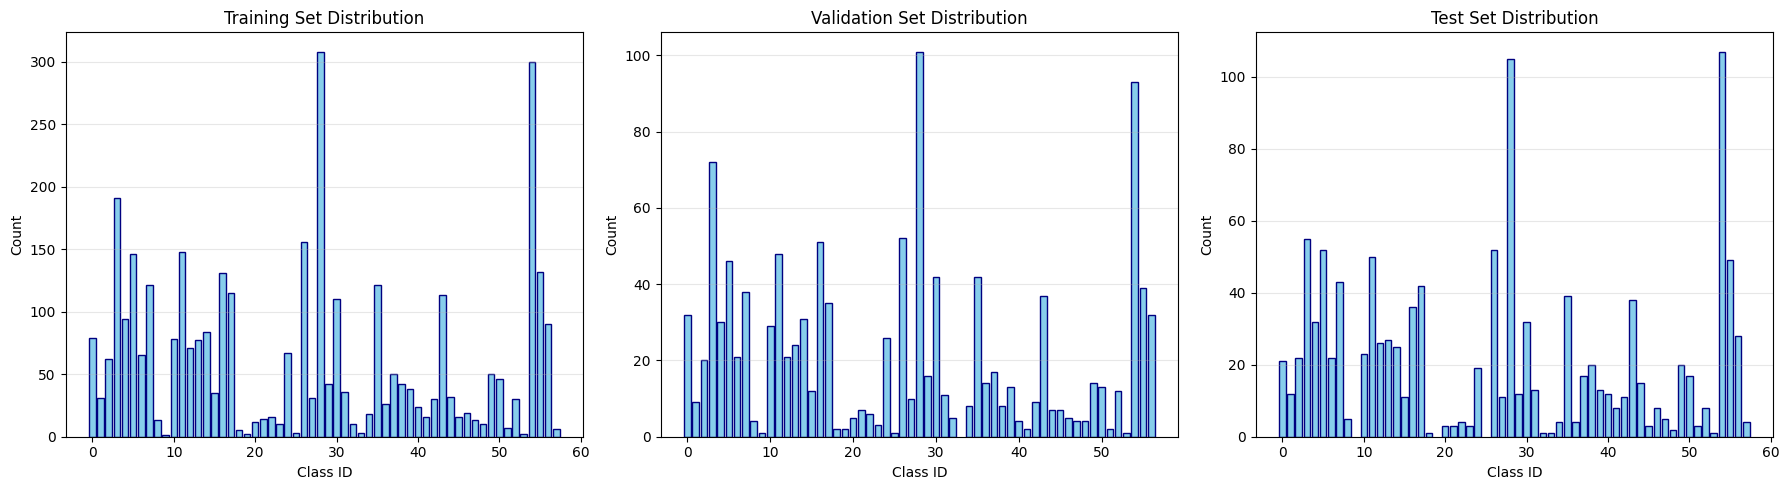

In [25]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.load_dataset(data_acq.data_dir)

# Analyze and visualize the class distribution
preprocessor.analyze_dataset(y_train, y_val, y_test)

## Train Model



In [27]:
class TrafficSignModel:
    """
    CNN model for traffic sign classification
    """

    def __init__(self, input_shape=(64, 64, 3), num_classes=58):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_cnn_model(self):
        """Build custom CNN architecture"""
        model = models.Sequential([
            # Block 1
            layers.Conv2D(32, (3, 3), activation='relu',
                         input_shape=self.input_shape, padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Block 2
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Block 3
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.4),

            # Dense layers
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        self.model = model
        return model

    def build_transfer_learning_model(self):
        """Build model using transfer learning (MobileNetV2)"""
        base_model = MobileNetV2(
            input_shape=self.input_shape,
            include_top=False,
            weights='imagenet'
        )

        # Freeze base model
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        self.model = model
        return model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        self.model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy',
                    keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')] # Changed to SparseTopKCategoricalAccuracy
        )

        print("\n✓ Model compiled successfully")
        return self.model

    def get_callbacks(self, model_path='models/'):
        """Get training callbacks"""
        os.makedirs(model_path, exist_ok=True)

        callbacks = [
            ModelCheckpoint(
                filepath=os.path.join(model_path, 'best_model.h5'),
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            TensorBoard(
                log_dir=os.path.join('logs', datetime.now().strftime("%Y%m%d-%H%M%S")),
                histogram_freq=1
            )
        ]

        return callbacks

    def train_model(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        """Train the model"""
        print("\n🚀 Starting model training...")

        callbacks = self.get_callbacks()

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        print("\n✓ Training completed!")
        return self.history

    def plot_training_history(self):
        """Plot training history"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy
        axes[0].plot(self.history.history['accuracy'], label='Train Accuracy')
        axes[0].plot(self.history.history['val_accuracy'], label='Val Accuracy')
        axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(alpha=0.3)

        # Loss
        axes[1].plot(self.history.history['loss'], label='Train Loss')
        axes[1].plot(self.history.history['val_loss'], label='Val Loss')
        axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('visualizations/training_history.png', dpi=300)
        print("✓ Saved training history visualization")

# Initialize and build model
ts_model = TrafficSignModel(input_shape=(64, 64, 3), num_classes=58)
model = ts_model.build_cnn_model()
ts_model.compile_model(learning_rate=0.001)

# Display model architecture
model.summary()



✓ Model compiled successfully


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,632,922 (17.67 MB)

 Trainable params: 4,630,490 (17.66 MB)

 Non-trainable params: 2,432 (9.50 KB)

## More epochs to increase accuracy

In [28]:
ts_model.train_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)


🚀 Starting model training...
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1681 - loss: 4.1158 - top_3_accuracy: 0.2736
Epoch 1: val_accuracy improved from -inf to 0.07583, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.1690 - loss: 4.1084 - top_3_accuracy: 0.2749 - val_accuracy: 0.0758 - val_loss: 5.0690 - val_top_3_accuracy: 0.1483 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4843 - loss: 1.9386 - top_3_accuracy: 0.6862
Epoch 2: val_accuracy did not improve from 0.07583
113/113 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.4846 - loss: 1.9370 - top_3_accuracy: 0.6865 - val_accuracy: 0.0250 - val_loss: 5.6861 - val_top_3_accuracy: 0.2058 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6524 - loss: 1.2637 - top_3_accuracy: 0.8179
Epoch 3: val_accuracy improved from 0.07583 to 0.42750, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.6526 - loss: 1.2626 - top_3_accuracy: 0.8181 - val_accuracy: 0.4275 - val_loss: 2.1413 - val_top_3_accuracy: 0.6592 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6911 - loss: 1.0783 - top_3_accuracy: 0.8587
Epoch 4: val_accuracy improved from 0.42750 to 0.71583, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.6914 - loss: 1.0771 - top_3_accuracy: 0.8589 - val_accuracy: 0.7158 - val_loss: 0.8847 - val_top_3_accuracy: 0.9108 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8177 - loss: 0.6253 - top_3_accuracy: 0.9282
Epoch 5: val_accuracy improved from 0.71583 to 0.89083, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.8178 - loss: 0.6247 - top_3_accuracy: 0.9283 - val_accuracy: 0.8908 - val_loss: 0.3568 - val_top_3_accuracy: 0.9617 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8687 - loss: 0.4599 - top_3_accuracy: 0.9574
Epoch 6: val_accuracy improved from 0.89083 to 0.92917, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.8688 - loss: 0.4595 - top_3_accuracy: 0.9574 - val_accuracy: 0.9292 - val_loss: 0.2625 - val_top_3_accuracy: 0.9725 - learning_rate: 0.0010
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9200 - loss: 0.2808 - top_3_accuracy: 0.9802
Epoch 7: val_accuracy improved from 0.92917 to 0.95000, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.9201 - loss: 0.2807 - top_3_accuracy: 0.9802 - val_accuracy: 0.9500 - val_loss: 0.1808 - val_top_3_accuracy: 0.9842 - learning_rate: 0.0010
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9452 - loss: 0.2126 - top_3_accuracy: 0.9888
Epoch 8: val_accuracy improved from 0.95000 to 0.95167, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9452 - loss: 0.2125 - top_3_accuracy: 0.9888 - val_accuracy: 0.9517 - val_loss: 0.1624 - val_top_3_accuracy: 0.9883 - learning_rate: 0.0010
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9224 - loss: 0.2528 - top_3_accuracy: 0.9878
Epoch 9: val_accuracy improved from 0.95167 to 0.97417, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9225 - loss: 0.2526 - top_3_accuracy: 0.9878 - val_accuracy: 0.9742 - val_loss: 0.1135 - val_top_3_accuracy: 0.9900 - learning_rate: 0.0010
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9583 - loss: 0.1524 - top_3_accuracy: 0.9934
Epoch 10: val_accuracy improved from 0.97417 to 0.97917, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9584 - loss: 0.1522 - top_3_accuracy: 0.9934 - val_accuracy: 0.9792 - val_loss: 0.0787 - val_top_3_accuracy: 0.9933 - learning_rate: 0.0010
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9784 - loss: 0.1087 - top_3_accuracy: 0.9961
Epoch 11: val_accuracy improved from 0.97917 to 0.98333, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9784 - loss: 0.1086 - top_3_accuracy: 0.9961 - val_accuracy: 0.9833 - val_loss: 0.0663 - val_top_3_accuracy: 0.9950 - learning_rate: 0.0010
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9767 - loss: 0.0841 - top_3_accuracy: 0.9988
Epoch 12: val_accuracy improved from 0.98333 to 0.98667, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9767 - loss: 0.0840 - top_3_accuracy: 0.9988 - val_accuracy: 0.9867 - val_loss: 0.0592 - val_top_3_accuracy: 0.9942 - learning_rate: 0.0010
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9793 - loss: 0.0795 - top_3_accuracy: 0.9978
Epoch 13: val_accuracy improved from 0.98667 to 0.98833, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9793 - loss: 0.0794 - top_3_accuracy: 0.9978 - val_accuracy: 0.9883 - val_loss: 0.0465 - val_top_3_accuracy: 0.9942 - learning_rate: 0.0010
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9919 - loss: 0.0495 - top_3_accuracy: 0.9994
Epoch 14: val_accuracy improved from 0.98833 to 0.99000, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9919 - loss: 0.0495 - top_3_accuracy: 0.9994 - val_accuracy: 0.9900 - val_loss: 0.0481 - val_top_3_accuracy: 0.9958 - learning_rate: 0.0010
Epoch 15/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9899 - loss: 0.0410 - top_3_accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.99000
113/113 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9899 - loss: 0.0409 - top_3_accuracy: 1.0000 - val_accuracy: 0.9867 - val_loss: 0.0500 - val_top_3_accuracy: 0.9958 - learning_rate: 0.0010
Epoch 16/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9908 - loss: 0.0373 - top_3_accuracy: 1.0000
Epoch 16: val_accuracy improved from 0.99000 to 0.99083, saving model to models/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9908 - loss: 0.0373 - top_3_accuracy: 1.0000 - val_accuracy: 0.9908 - val_loss: 0.0436 - val_top_3_accuracy: 0.9958 - learning_rate: 0.0010
Epoch 17/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9898 - loss: 0.0380 - top_3_accuracy: 0.9993
Epoch 17: val_accuracy did not improve from 0.99083
113/113 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9898 - loss: 0.0380 - top_3_accuracy: 0.9993 - val_accuracy: 0.9908 - val_loss: 0.0502 - val_top_3_accuracy: 0.9958 - learning_rate: 0.0010
Epoch 18/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9931 - loss: 0.0371 - top_3_accuracy: 1.0000
Epoch 18: val_accuracy did not improve from 0.99083
113/113 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9931 - loss: 0.0371 - top_3_accuracy: 1.0000 - val_accuracy: 0.9900 - val_loss: 0.0480 - val_top_3_accuracy: 0.9958 - learning_rate: 0.0010
Epoch 19/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9961 - loss: 0.0231 

113/113 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9943 - loss: 0.0248 - top_3_accuracy: 1.0000 - val_accuracy: 0.9925 - val_loss: 0.0417 - val_top_3_accuracy: 0.9958 - learning_rate: 0.0010
Epoch 21/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9935 - loss: 0.0319 - top_3_accuracy: 0.9982
Epoch 21: val_accuracy did not improve from 0.99250
113/113 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9935 - loss: 0.0319 - top_3_accuracy: 0.9982 - val_accuracy: 0.9850 - val_loss: 0.0497 - val_top_3_accuracy: 0.9958 - learning_rate: 0.0010
Epoch 22/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9934 - loss: 0.0253 - top_3_accuracy: 1.0000
Epoch 22: val_accuracy did not improve from 0.99250
113/113 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9934 - loss: 0.0253 - top_3_accuracy: 1.0000 - val_accuracy: 0.9892 - val_loss: 0.0420 - val_top_3_accuracy: 0.9950 - learning_rate: 0.0010
Epoch 23/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9937 - loss: 0.0270 

113/113 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9915 - loss: 0.0294 - top_3_accuracy: 1.0000 - val_accuracy: 0.9933 - val_loss: 0.0385 - val_top_3_accuracy: 0.9983 - learning_rate: 5.0000e-04
Epoch 29/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9962 - loss: 0.0183 - top_3_accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.99333
113/113 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9962 - loss: 0.0183 - top_3_accuracy: 1.0000 - val_accuracy: 0.9908 - val_loss: 0.0438 - val_top_3_accuracy: 0.9942 - learning_rate: 5.0000e-04
Epoch 30/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9962 - loss: 0.0116 - top_3_accuracy: 0.9999
Epoch 30: val_accuracy did not improve from 0.99333
113/113 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9962 - loss: 0.0116 - top_3_accuracy: 0.9999 - val_accuracy: 0.9900 - val_loss: 0.0366 - val_top_3_accuracy: 0.9958 - learning_rate: 5.0000e-04
Epoch 31/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9969 - l

113/113 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9981 - loss: 0.0067 - top_3_accuracy: 1.0000 - val_accuracy: 0.9942 - val_loss: 0.0364 - val_top_3_accuracy: 0.9975 - learning_rate: 2.5000e-04
Epoch 40/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9996 - loss: 0.0040 - top_3_accuracy: 1.0000
Epoch 40: val_accuracy did not improve from 0.99417
113/113 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9996 - loss: 0.0040 - top_3_accuracy: 1.0000 - val_accuracy: 0.9942 - val_loss: 0.0331 - val_top_3_accuracy: 0.9975 - learning_rate: 2.5000e-04
Epoch 41/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0048 - top_3_accuracy: 1.0000
Epoch 41: val_accuracy did not improve from 0.99417
113/113 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 1.0000 - loss: 0.0048 - top_3_accuracy: 1.0000 - val_accuracy: 0.9942 - val_loss: 0.0315 - val_top_3_accuracy: 0.9975 - learning_rate: 2.5000e-04
Epoch 42/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9983 - l